In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from numpy.random import randn
from matplotlib.patches import Ellipse


In [5]:
# Discretized continuous-time kinematic filters.


# Initialization
#
#1. Initialize the state of the filter
#2. Initialize our belief in the state
#
# Predict
#
#1. Use process model to predict state at the next time step
#2. Adjust belief to account for the uncertainty in prediction    
#
# Update
#
#1. Get a measurement and associated belief about its accuracy
#2. Compute residual between estimated state and measurement
#3. Compute scaling factor based on whether the measurement or prediction is more accurate
#4. set state between the prediction and measurement based on scaling factor
#5. update belief in the state based on how certain we are in the measurement


In [14]:
# Helper Functions
def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

def plot_cov_contour(x,y,cov_mat,color = 'k'):
    U,s,v = np.linalg.svd(cov_mat)
    orientation = math.atan2(U[1,0],U[0,0])
    a = np.degrees(orientation)
    w = math.sqrt(s[0]) * 2.
    h = math.sqrt(s[1]) * 2.
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h, angle=a,
                  edgecolor=color, fc='None', lw=2)
    ell.set_facecolor('none')
    return ell

def Q_discrete_white_noise(dim,dt = 1.,var = 1):
    assert dim == 2 or dim == 3
    if dim == 2:
        Q = np.array([[.25*dt**4, .5*dt**3],
                   [ .5*dt**3,    dt**2]], dtype=float)
    else:
        Q = np.array([[.25*dt**4, .5*dt**3, .5*dt**2],
                   [ .5*dt**3,    dt**2,       dt],
                   [ .5*dt**2,       dt,        1]], dtype=float)
    return Q * var

def predict(x,p,f,q=0,b=0,u=0):
    " INPUTS "
    " x ,  P : the state belief and covariance "
    " F ,  Q : the process model and noise covariance "
    " B ,  u : Optionally, the control input and function "
    # x = Fx + Bu 
    x_new = np.dot(f,x) + b*u
    # P = FPF' + Q --> project system uncertainty into state space
    p_new = np.dot(f,np.dot(p,f.T)) + q
    return x_new,p_new

def update(x, P, z, R, H):
    " INPUTS "
    " x ,  P : the state belief and covariance "
    " z ,  R,  H: the measurement, measurement noise covariance, and measurement function "
    # x = Fx + Bu
    # error (residual) between measurement and prediction
    y = z - np.dot(H, x)
    # project system uncertainty into measurement space
    S = np.dot(H, np.dot(P, H.T)) + R
    # map system uncertainty into kalman gain
    # K = [P/S] * h --> (uncertainty pred/uncertainty measure) * 
    try:
        K = np.dot(P,np.dot(H.T, linalg.inv(S)))
    except:
        K = np.dot(P, np.dot(H.T, 1/S))
    # predict new x with residual scaled by the kalman gain
    x = x + np.dot(K, y)
    
    # P = (I-KH)P(I-KH)' + KRK'
    KH = np.dot(K, H)
    try:
        I_KH = np.eye(KH.shape[0]) - KH
    except:
        I_KH = np.array(1 - KH)
    #P = np.dot(I_KH,np.dot(P, I_KH.T)) + np.dot(K,np.dot(R, K.T)) 
    P = P - np.dot(np.dot(K, H),(P))
    
    return x,P

Initially:
mu:  [ 10.    4.5]
Cov: [[500   0]
 [  0  49]]


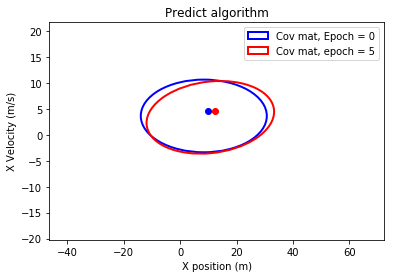

After 5 Epochs:
mu:  [ 12.25   4.5 ]
Cov: [[ 512.25   24.5 ]
 [  24.5    49.  ]]


In [15]:
# 2d Kalman filter 
### Predict
n     = 200
frate = 10
dt    = np.full((n,),1/frate)
dt[0] = 0
dt    = np.cumsum(dt)
# Initialize 
# States
mux = np.array([10.,4.5]) # initial position/velocity
P   = np.diag([500, 49])  # initial covariance matrix
x_init,y_init = np.random.multivariate_normal(mux, P, 100).T # Creating normal distribution
# State transition Matrix
F = np.array([[1, 1/frate], # pos2 = pos1 + dt * vel1
              [0, 1]])      # vel2 = vel1
# Visualize contour plot of intitial covariance mat
ax = plt.subplot(111)
plt.scatter(mux[0],mux[1],color='b')
ell_init = plot_cov_contour(x_init,y_init,P,'b')
print("Initially:")
print("mu: ",mux)
print("Cov:",P)
########################################
# Run through 5 iterations of predict
for _ in range(5):
    mux,P = predict(x=mux,p=P,f=F)
# Update contour plot for final covariance mat (5 epochs of predict)
x_fin,y_fin = np.random.multivariate_normal(mux, P, 100).T # Creating normal distribution
ell_final = plot_cov_contour(x_fin,y_fin,P,'r')
plt.scatter(mux[0],mux[1],color='r')
ax.add_patch(ell_init)
ax.add_patch(ell_final)
########################################
xvals = np.vstack([x_init,x_fin])
yvals = np.vstack([y_init,y_fin])
plt.xlim([np.amin(xvals),np.amax(xvals)])
plt.ylim([np.amin(yvals),np.amax(yvals)])
plt.xlabel('X position (m)')
plt.ylabel('X Velocity (m/s)')
plt.legend(['Cov mat, Epoch = 0','Cov mat, epoch = 5'])

plt.title('Predict algorithm')

plt.show()
print("After 5 Epochs:")
print("mu: ",mux)
print("Cov:",P)

In [16]:
### Kalman Filter:  Update
# Adding White Process Noise
Q   = Q_discrete_white_noise(dim=2,dt = 1,var=2.35)
mux = np.array([10.,4.5]) # initial position/velocity
P   = np.diag([500, 500])  # initial covariance matrix
# State transition Matrix
F = np.array([[1, 0.3], # pos2 = pos1 + dt * vel1
              [0, 1]])  # vel2 = vel1
mux,P = predict(x=mux,p=P,f=F,q=0)
print("mu: ",mux)
print("Cov:",P)
print("White process noise: ",Q)
mux,P = predict(x=mux,p=P,f=F,q=Q)
print("mu: ",mux)
print("Cov:",P)
### Update
H = np.array([[1., 0.]])
R = np.array([[5.]])
z = 1.
x, P = update(mux, P, z, R, H)
print(mux)
print("x = ",x)

mu:  [ 11.35   4.5 ]
Cov: [[ 545.  150.]
 [ 150.  500.]]
White process noise:  [[ 0.5875  1.175 ]
 [ 1.175   2.35  ]]
mu:  [ 12.7   4.5]
Cov: [[ 680.5875  301.175 ]
 [ 301.175   502.35  ]]
[ 12.7   4.5]
x =  [ 1.08532828 -0.63974876]


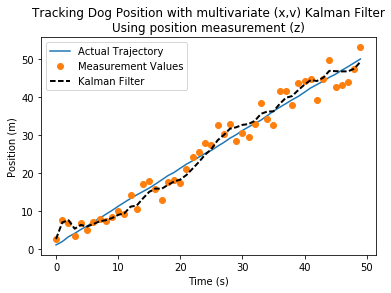

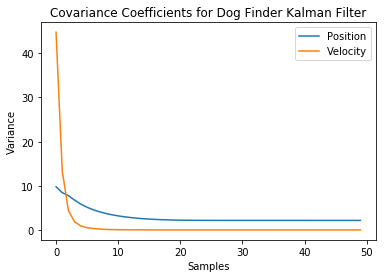

In [17]:
# Putting it together:
# Initialization...
count   = 50
dim_x   = 2 # state dimension (position/velocity)
dim_z   = 1 # measurement dimension (sensor recording)
dt      = 1
p_coeff = np.array([500,49]); r_coeff = 10; q_coeff = 0.01
mux = np.zeros((dim_x,))         # initial position/velocity
P   = np.diag([1,1]) * p_coeff   # initial state covariance matrix
F = np.array([[1, dt],           # State Transition function        [pos2 = pos1 + dt * vel1              ]
              [0, 1]])           #                                  [vel2 = vel1H   = np.array([1,0])     ]
R   = np.diag([1]) * r_coeff     # initial measurement covariance matrix
Q = Q_discrete_white_noise(dim=2,dt=dt,var=q_coeff)   # initial process covariance matrix
## Generate Synthetic Data
track, zs = compute_dog_data(r_coeff, q_coeff, count)
# run the kalman filter and store the results
xs, cov = [], []
for z in zs:
    mux,P = predict(mux,p=P,f=F,q=Q,b=0,u=0) # Prior
    mux,P = update(mux, P, z, R, H)          # Posterior
    xs.append(mux)
    cov.append(P)
xs  = np.array(xs)
cov = np.array(cov)
# Visualize Results
ts = np.arange(len(track))
plt.plot(ts,track)
plt.plot(ts,zs,'o')
plt.plot(ts,xs[:,0],'k--',linewidth = 2)
plt.legend(['Actual Trajectory','Measurement Values','Kalman Filter'])
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Tracking Dog Position with multivariate (x,v) Kalman Filter\nUsing position measurement (z)')
plt.show()

plt.subplot(111)
plt.plot(cov[:,0,0])
plt.plot(cov[:,1,1])
plt.legend(['Position','Velocity'])
plt.title('Covariance Coefficients for Dog Finder Kalman Filter')
plt.xlabel('Samples')
plt.ylabel('Variance')
plt.show()